# Analyse des fichiers bruit 


# 1)  Analyse du fichier bruit aprés preprocessing

- Analyse descriptive 

- Analyse de la colonne "DN" qui représente le bruit par segment

- Analysde d ela colonne "length" qui représente la longueur par segment


# 2) Analyse dy fichier bruit aprés score 

- Analyse descriptive 
- Analyse de la colonne "Score_distance_bruit" qui représente le bruit par segment 
- Analyse de la colonne "length" qui représente la longueur par segment 

# 3)  Relation entre score_distance_bruit et length

- Corrélation 


### Importation des librairies 

In [ ]:
import os
import sys
sys.path.append("../")
sys.path.append("../../")
os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib
from scipy.stats import pearsonr, gamma, kstest, ks_2samp, wilcoxon
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import scipy.stats as scs
import scipy.stats as stats

### Importattion du fichier bruit 

In [ ]:
edges_buffer_bruit_wavg_path = "/home/alexandre-ober/Bureau/itineraires_multicriteres/backend/score_calculation_it/output_data/network/edges/edges_buffered_bruit_wavg_bounding.gpkg"
bruit_pre = gpd.read_file(edges_buffer_bruit_wavg_path)
bruit_pre.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,theme,soustheme,identifiant,idexterne,siret,datecreation,gid,DN,DN_scaled,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,ADMINISTRATION,Métropole,S5759,69M,20004697700019,2014-11-14,5956,6,0.833333,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.495,...,ADMINISTRATION,Métropole,S5759,69M,20004697700019,2014-11-14,5956,6,0.833333,"POLYGON ((1846084.987 5172144.368, 1846084.434..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,10.536,...,ADMINISTRATION,Métropole,S5759,69M,20004697700019,2014-11-14,5956,6,0.833333,"POLYGON ((1846122.641 5172142.426, 1846122.369..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.631,...,ADMINISTRATION,Métropole,S5759,69M,20004697700019,2014-11-14,5956,6,0.833333,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,ADMINISTRATION,Métropole,S5759,69M,20004697700019,2014-11-14,5956,6,0.833333,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [22]:
bruit_pre.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'bridge', 'ref',
       'junction', 'service', 'access', 'tunnel', 'est_width', 'area', 'id',
       'nom', 'theme', 'soustheme', 'identifiant', 'idexterne', 'siret',
       'datecreation', 'gid', 'DN', 'DN_scaled', 'geometry'],
      dtype='object')

# Explication des colonnes : 

U : ID du départ du segment 

V : ID d'arrivée du segment 

OSMID : ID unique du segment 

Oneway : Sens unique True or False 

Highway : Type de route 

Max speed : Vitesse max sur la route 

Length : Longueur de la route en mètre

Est_width : Largeur en mètres

Area : Aire du segement

DN_wavg : Moyenne pondérée du bruit par segment 

Dn_wavg_scaled : Mise à l'échelle de DN_wavg 

Géometry : Type de géométrie (Polygon ici), aves ses coordonnées géographiques 


In [23]:
nb_line = bruit_pre.shape[0] 
nb_col = bruit_pre.shape[1]  

print(f"Nombre de lignes dans bruit: {nb_line}")
print(f"Nombre de colonnes dans bruit: {nb_col}")

Nombre de lignes dans bruit: 209441
Nombre de colonnes dans bruit: 34


In [24]:
bruit_pre.dtypes

u                  int64
v                  int64
key                int64
osmid             object
oneway              bool
name              object
highway           object
maxspeed          object
reversed          object
length           float64
from               int64
to                 int64
lanes             object
width             object
bridge            object
ref               object
junction          object
service           object
access            object
tunnel            object
est_width         object
area              object
id                object
nom               object
theme             object
soustheme         object
identifiant       object
idexterne         object
siret             object
datecreation      object
gid                int64
DN                 int64
DN_scaled        float64
geometry        geometry
dtype: object

#### Description 

In [25]:
bruit_pre.describe()

,u,v,key,length,from,to,gid,DN,DN_scaled
count,2.094410e+05,2.094410e+05,209441.000000,209441.000000,2.094410e+05,2.094410e+05,209441.0,209441.000000,209441.000000
mean,5.246434e+09,6.707972e+09,0.015866,47.918176,6.536575e+09,5.417831e+09,5956.0,3.514828,0.419138
std,4.305330e+09,4.263122e+09,0.166731,74.245192,4.347253e+09,4.272436e+09,0.0,1.980036,0.330006
min,1.434030e+05,1.434350e+05,0.000000,0.011000,1.434030e+05,1.434030e+05,5956.0,1.000000,0.000000
25%,1.383187e+09,2.485985e+09,0.000000,8.545000,2.233802e+09,1.500109e+09,5956.0,1.000000,0.000000
50%,4.065145e+09,6.427239e+09,0.000000,23.538000,6.283640e+09,4.228968e+09,5956.0,4.000000,0.500000
75%,9.320983e+09,1.145417e+10,0.000000,59.784000,1.141553e+10,9.474214e+09,5956.0,5.000000,0.666667
max,1.238328e+10,1.238328e+10,4.000000,3165.715000,1.238328e+10,1.238328e+10,5956.0,7.000000,1.000000



#### Voir s'il y a des valeurs manquantes 

In [26]:
bruit_pre.isnull().sum()

u               0
v               0
key             0
osmid           0
oneway          0
name            0
highway         0
maxspeed        0
reversed        0
length          0
from            0
to              0
lanes           0
width           0
bridge          0
ref             0
junction        0
service         0
access          0
tunnel          0
est_width       0
area            0
id              0
nom             0
theme           0
soustheme       0
identifiant     0
idexterne       0
siret           0
datecreation    0
gid             0
DN              0
DN_scaled       0
geometry        0
dtype: int64

65971 valeurs manquantes sur le fichier bruit

#### Voir s'il y a des doublons 

In [27]:
bruit_pre.duplicated().sum()

0

#### Regarder le pourcentage de contenu par colonne 

In [28]:
# Calcul du pourcentage de valeurs non nulles par colonne
percent_non_null = bruit_pre.isnull().mean() * 100

# Affichage des résultats sous forme de tableau
print(percent_non_null)


u               0.0
v               0.0
key             0.0
osmid           0.0
oneway          0.0
name            0.0
highway         0.0
maxspeed        0.0
reversed        0.0
length          0.0
from            0.0
to              0.0
lanes           0.0
width           0.0
bridge          0.0
ref             0.0
junction        0.0
service         0.0
access          0.0
tunnel          0.0
est_width       0.0
area            0.0
id              0.0
nom             0.0
theme           0.0
soustheme       0.0
identifiant     0.0
idexterne       0.0
siret           0.0
datecreation    0.0
gid             0.0
DN              0.0
DN_scaled       0.0
geometry        0.0
dtype: float64


In [29]:
bruit_pre.duplicated().sum()

0

Aucun doublon sur le fichier bruit


### Analyse de la colonne DN

In [30]:
nb_line = bruit_pre['DN'].shape[0] 

print(f"Nombre de lignes dans 'DN': {nb_line}")

Nombre de lignes dans 'DN': 209441


#### Description 

In [31]:
bruit_pre['DN'].describe()

count    209441.000000
mean          3.514828
std           1.980036
min           1.000000
25%           1.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: DN, dtype: float64

Détection des valeurs aberrantes ou atypiques (OUTLIERS)

Méthode 1 : Regarder si les valeurs sont en dehors de l'intervalle (Q1 - 1.5 x IQR, Q3 +1.5 x IQR)

In [32]:
# Calcul 
Q1 = bruit_pre['DN'].quantile(0.25)
Q3 = bruit_pre['DN'].quantile(0.75)
IQR = Q3 - Q1

# Définir limites basse et haute
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Détection des valeurs aberrantes
outliers = bruit_pre[(bruit_pre['DN'] < lower_bound) | (bruit_pre['DN'] > upper_bound)]

print(f"Valeurs aberrantes détectées :\n{outliers}")

Valeurs aberrantes détectées :
Empty GeoDataFrame
Columns: [u, v, key, osmid, oneway, name, highway, maxspeed, reversed, length, from, to, lanes, width, bridge, ref, junction, service, access, tunnel, est_width, area, id, nom, theme, soustheme, identifiant, idexterne, siret, datecreation, gid, DN, DN_scaled, geometry]
Index: []

[0 rows x 34 columns]


Aucune valeur détécté ce qui est normale par rapport au valeurs dans DN qui sont des valeurs non continues

Visualisation de la distribution 

Text(0, 0.5, 'occurence')

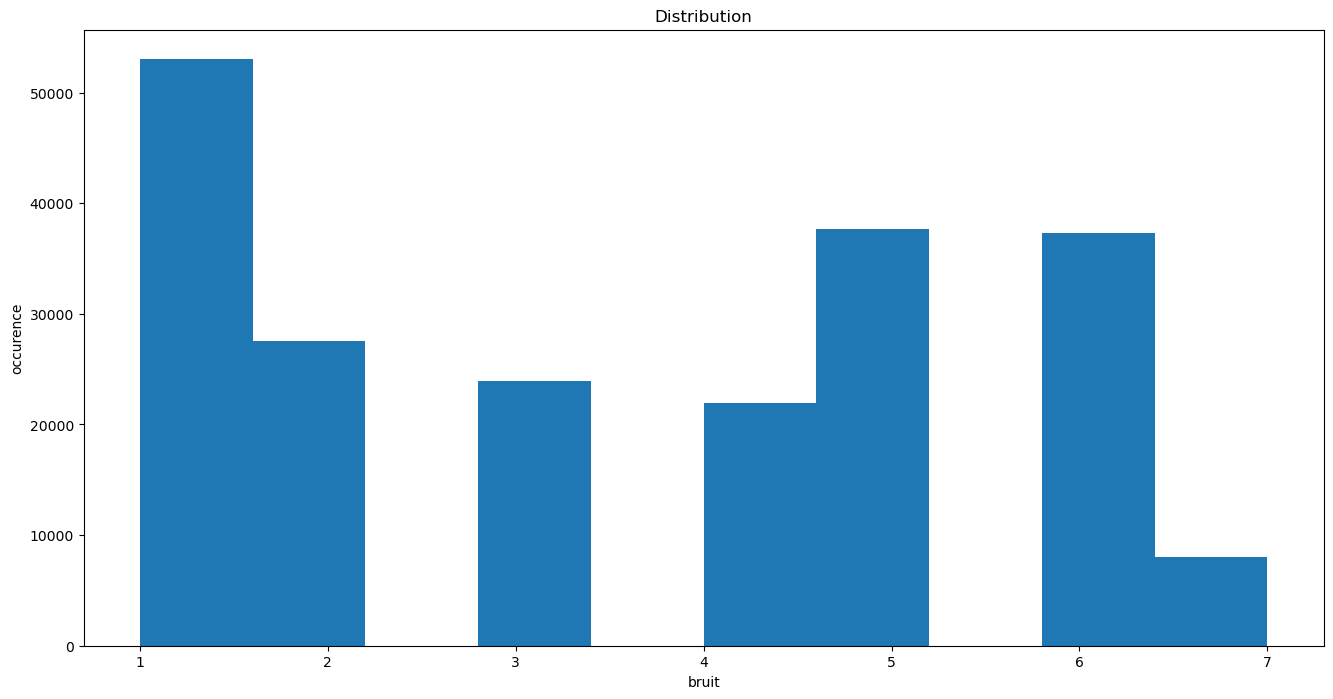

In [33]:
plt.figure(figsize=(16,8))
plt.hist(bruit_pre['DN'])
plt.title("Distribution")
plt.xlabel('bruit')
plt.ylabel('occurence')

#### Visualisation dans un boxplot 

count    209441.000000
mean          3.514828
std           1.980036
min           1.000000
25%           1.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: DN, dtype: float64

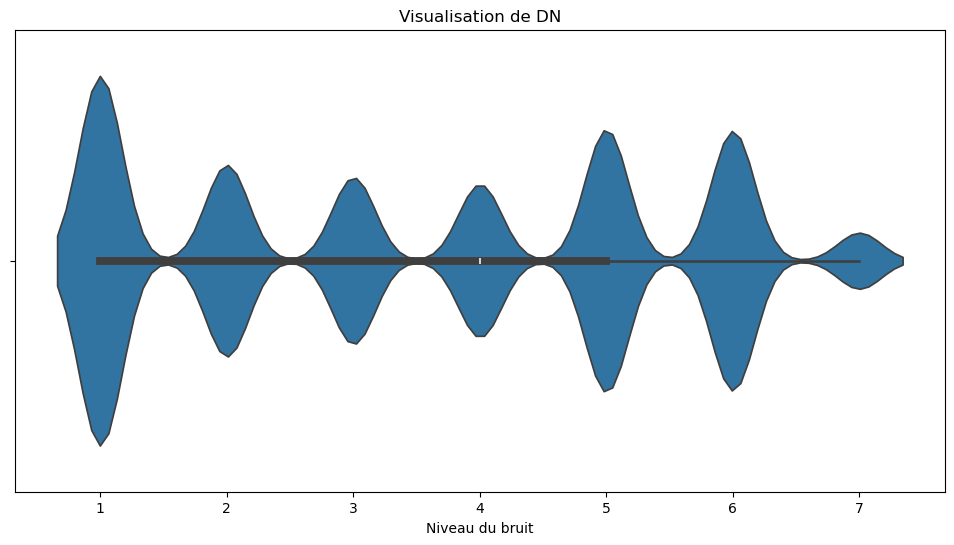

In [34]:
# Remplacer par un diagramme en violon

plt.figure(figsize=(12,6))
sns.violinplot(data=bruit_pre, x='DN')
plt.xlabel('Niveau du bruit')
plt.title('Visualisation de DN')  
bruit_pre['DN'].describe()

Point blanc = Médiane  
Plage interquartile = Large barre grise au milieu 

Text(0.5, 1.0, 'Visualisation de DN')

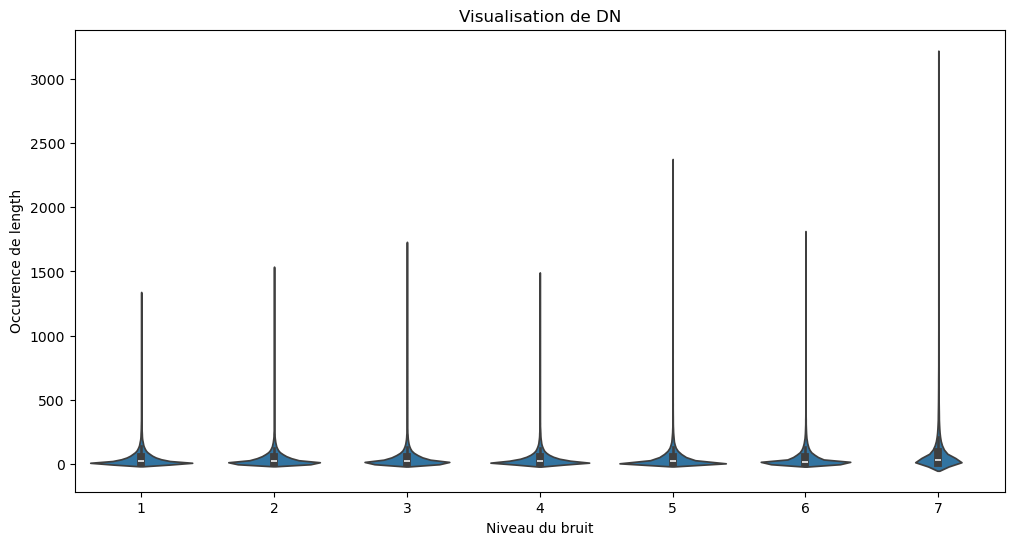

In [35]:
plt.figure(figsize=(12,6))
sns.violinplot(data=bruit_pre, x='DN', y='length')
plt.xlabel('Niveau du bruit')
plt.ylabel('Occurence de length')
plt.title('Visualisation de DN')  

(0.0, 500.0)

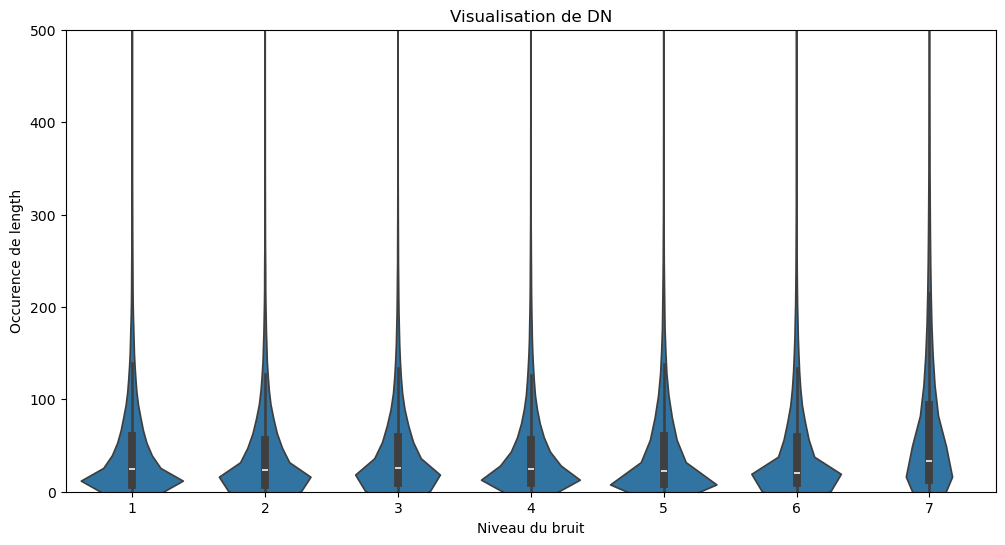

In [36]:
plt.figure(figsize=(12,6))
sns.violinplot(data=bruit_pre, x='DN', y='length')
plt.xlabel('Niveau du bruit')
plt.ylabel('Occurence de length')
plt.title('Visualisation de DN') 
plt.ylim(0,500)

(0.0, 200.0)

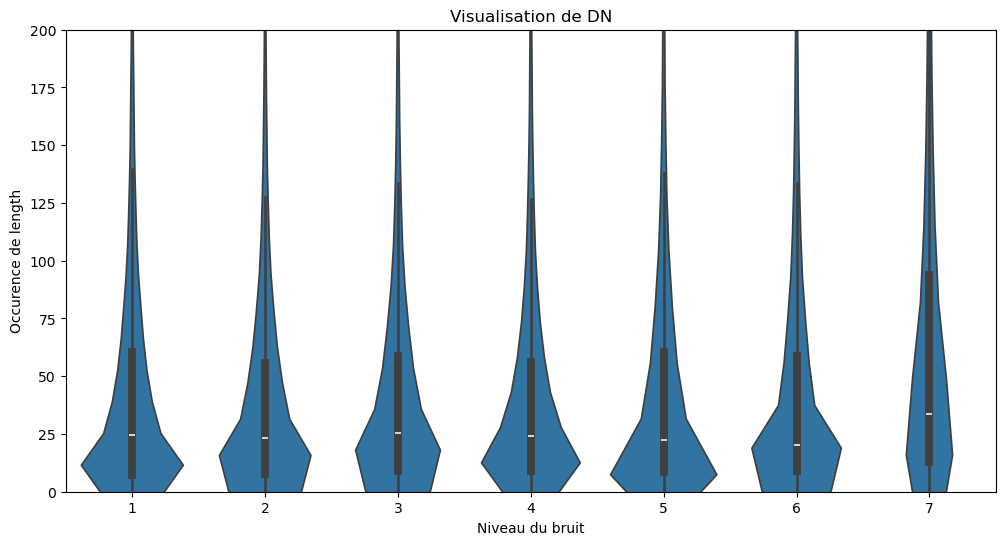

In [37]:
plt.figure(figsize=(12,6))
sns.violinplot(data=bruit_pre, x='DN', y='length')
plt.xlabel('Niveau du bruit')
plt.ylabel('Occurence de length')
plt.title('Visualisation de DN') 
plt.ylim(0,200)

Chaque violon represente la distribution des occurences pour un niveau spécifique de bruit (de 1 à7) 

Les formes montrernt la densité de svaleurs à chaque niveau de bruit plus un erégion est large plus les occurences sont fréquentes 

Les médianes ne varient pas beaucoup 

les distributions sont globalement similaire (forme et étendue) donc que le niveau de bruit na pas dimpact significatif sur la variable length

(0.0, 7.0)

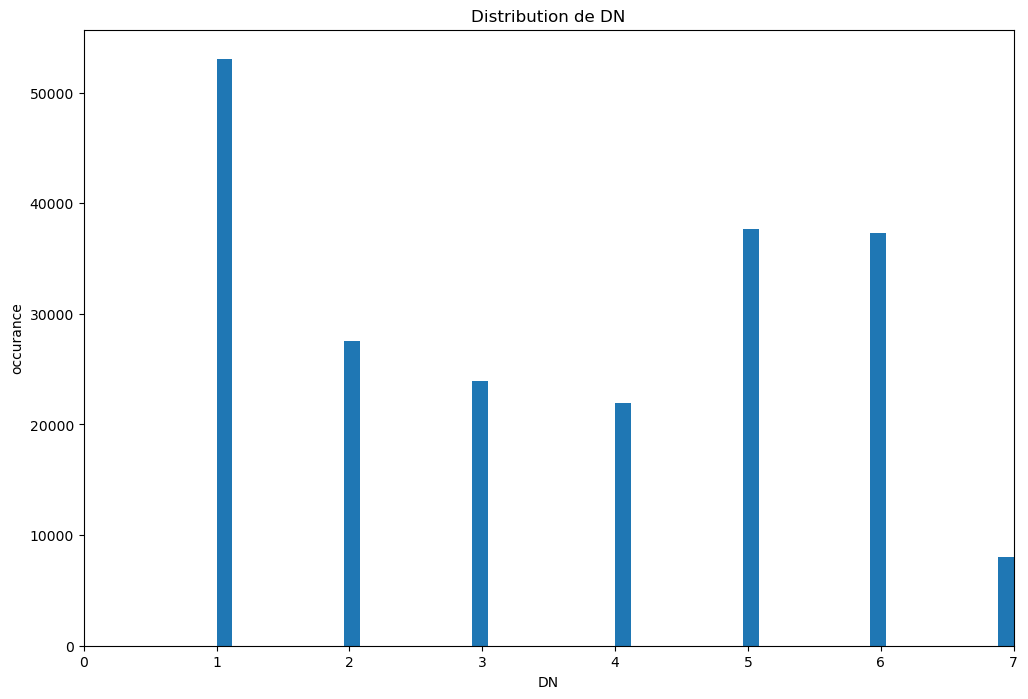

In [38]:
plt.figure(figsize=(12,8))
plt.hist(bruit_pre['DN'], bins=50)
plt.title("Distribution de DN")
plt.xlabel('DN')
plt.ylabel('occurance')
plt.xlim(0, 7)  

### Analyse de la colonne length

In [39]:
nb_line = bruit_pre['length'].shape[0] 

print(f"Nombre de lignes dans 'length': {nb_line}")

Nombre de lignes dans 'length': 209441


In [40]:
bruit_pre['length'].duplicated().sum()

102895

### Descrition

In [41]:
bruit_pre['length'].describe()

count    209441.000000
mean         47.918176
std          74.245192
min           0.011000
25%           8.545000
50%          23.538000
75%          59.784000
max        3165.715000
Name: length, dtype: float64

Détection de segment trop long

Méthode 1 : Regarder si les valeurs sont en dehors de l'intervalle (Q1 - 1.5 x IQR, Q3 +1.5 x IQR)

In [42]:
# Calcul 
Q1 = bruit_pre['length'].quantile(0.25)
Q3 = bruit_pre['length'].quantile(0.75)
IQR = Q3 - Q1

# Définir limites basse et haute
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Détection des segments longs
seg_long = bruit_pre['length'][(bruit_pre['length'] < lower_bound) | (bruit_pre['length'] > upper_bound)]

print(f"Segments longs détectés :\n{seg_long}")

Segments longs détectés :
56        162.166
66        159.057
76        141.680
97        200.060
119       189.845
           ...   
209338    176.776
209362    149.077
209368    136.830
209371    223.980
209412    283.418
Name: length, Length: 14872, dtype: float64


Méthode 2 : Méthode du Z-Score (x - moy / écart-type)

In [43]:
# Calcul du Z-score
z_scores = stats.zscore(bruit_pre['length'])

# Détection des segments longs (Z-score > 3 ou < -3)
seg_long = bruit_pre['length'][abs(z_scores) > 3]

print(f"Segments longs détectés :\n{seg_long}")

# Voir les 10 premier 
#print(z_scores[:10])  

Segments longs détectés :
517       276.770
530       308.037
708       358.339
751       357.042
764       719.372
           ...   
208909    410.187
208929    297.410
209194    491.820
209328    284.023
209412    283.418
Name: length, Length: 3554, dtype: float64


In [44]:
seg_long.max()
print(f"Le segment le plus long détecté :\n{seg_long.max()}")

Le segment le plus long détecté :
3165.715


3km cela est possible 

In [45]:
seg_long.min()
print(f"Le segment le plus court détecté :\n{seg_long.min()}")

Le segment le plus court détecté :
270.696


(0.0, 20.0)

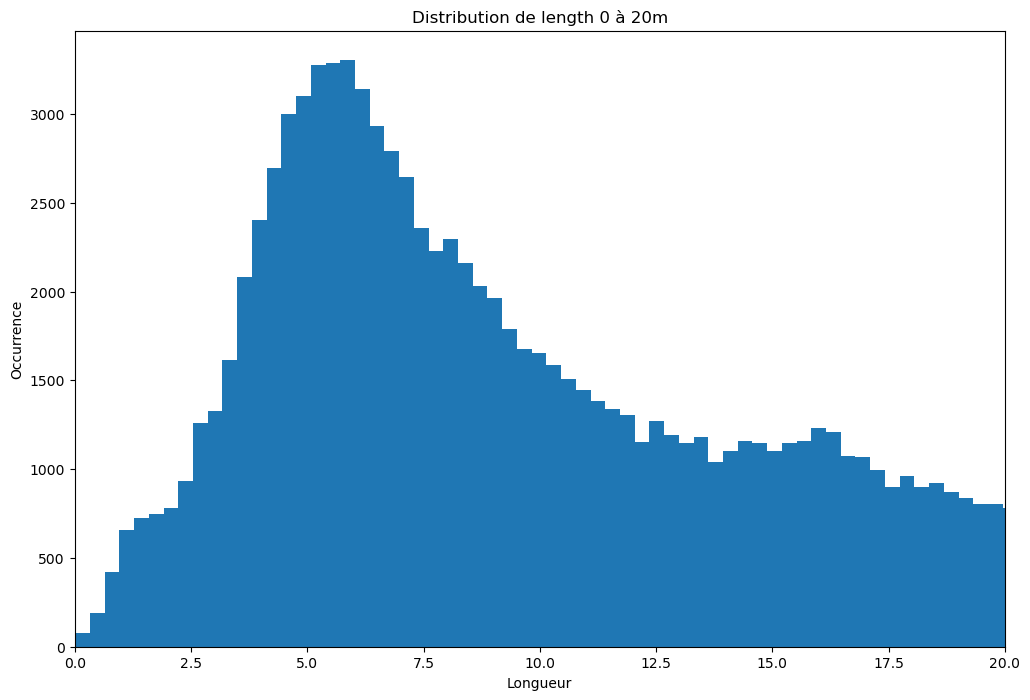

In [46]:
plt.figure(figsize=(12, 8))
plt.hist(bruit_pre['length'], bins=10000)
plt.title("Distribution de length 0 à 20m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')
plt.xlim(0, 20)


(20.0, 100.0)

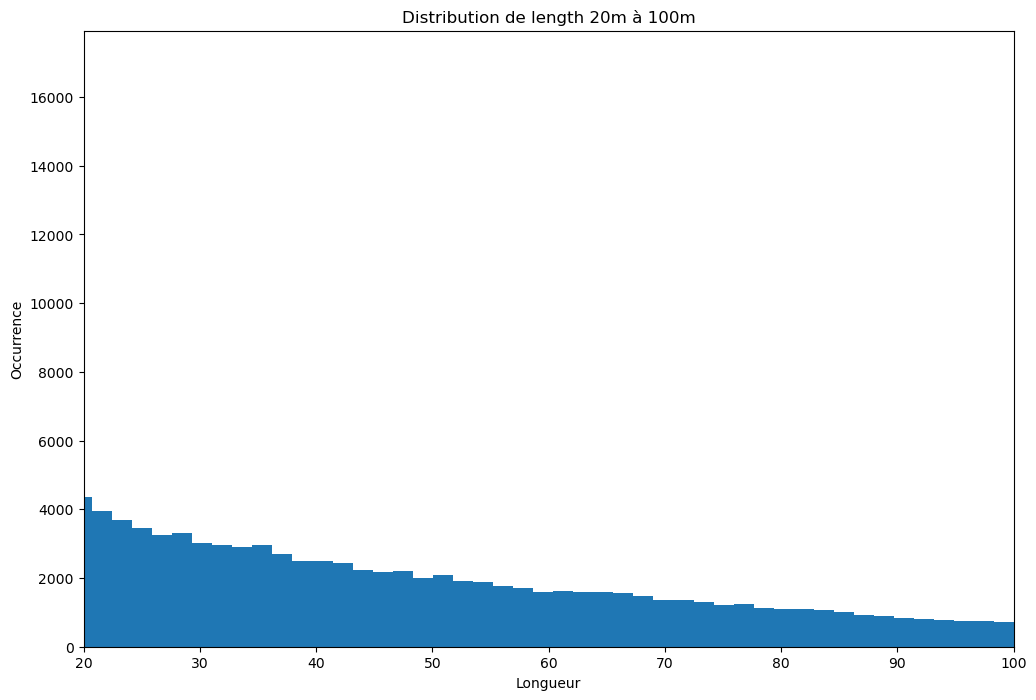

In [47]:
plt.figure(figsize=(12, 8))
plt.hist(bruit_pre['length'], bins='auto') 
plt.title("Distribution de length 20m à 100m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')
plt.xlim(20, 100)

Text(0, 0.5, 'Occurrence')

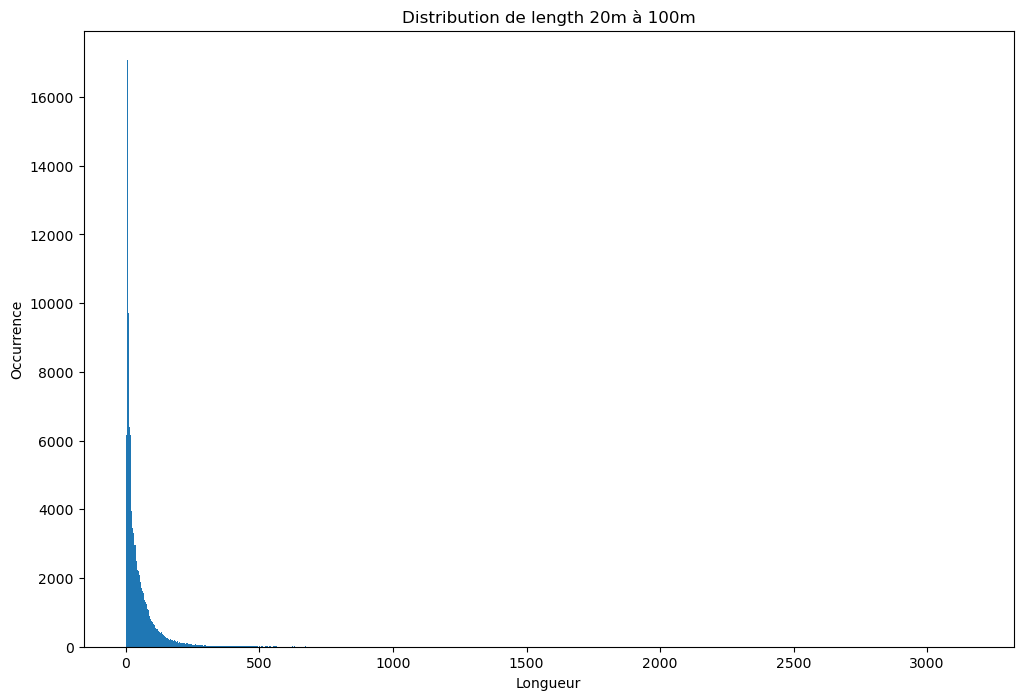

In [48]:
plt.figure(figsize=(12, 8))
plt.hist(bruit_pre['length'], bins='auto') 
plt.title("Distribution de length 20m à 100m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')

 ## Analyse du fichier score bruit 

In [53]:
edges_buffer_total_score_distance_bruit_path = "/home/alexandre-ober/Bureau/itineraires_multicriteres/backend/score_calculation_it/output_data/network/edges/edges_buffered_total_score_distance_bruit_bounding.gpkg"
score_bruit = gpd.read_file(edges_buffer_total_score_distance_bruit_path)

score_bruit.head()

,u,v,key,osmid,oneway,name,highway,maxspeed,reversed,length,...,idexterne,siret,datecreation,gid,DN,DN_scaled,total_score_bruit,score_distance_bruit,bruit_score,geometry
0,143403,21714981,0,120412669,False,Rue Professeur Morat,residential,30,False,12.119,...,69M,20004697700019,2014-11-14,5956,6,0.833333,6,72.714,9.97,"POLYGON ((1846109.564 5172145.602, 1846110.144..."
1,143403,9226919131,0,521119804,True,Avenue Jean Mermoz,primary,50,False,26.495,...,69M,20004697700019,2014-11-14,5956,6,0.833333,6,158.970,9.93,"POLYGON ((1846084.987 5172144.368, 1846084.434..."
2,143403,9226887756,0,120412669,False,Rue Professeur Morat,residential,30,True,10.536,...,69M,20004697700019,2014-11-14,5956,6,0.833333,6,63.216,9.97,"POLYGON ((1846122.641 5172142.426, 1846122.369..."
3,143403,10810932922,0,521119804,True,Avenue Jean Mermoz,primary,50,False,15.631,...,69M,20004697700019,2014-11-14,5956,6,0.833333,6,93.786,9.96,"POLYGON ((1846109.345 5172134.084, 1846108.797..."
4,21714981,9226922647,0,4087154,True,Rue Professeur Morat,unclassified,30,False,8.969,...,69M,20004697700019,2014-11-14,5956,6,0.833333,6,53.814,9.98,"POLYGON ((1846096.611 5172125.102, 1846096.085..."


In [54]:
nb_lines = score_bruit.shape[0]
print(f"Le nombre de lignes du fichier est de :\n{nb_lines} lignes")

Le nombre de lignes du fichier est de :
209441 lignes


In [55]:
print(f"Le type de colonne du fichier :\n{score_bruit.columns}")

Le type de colonne du fichier :
Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'bridge', 'ref',
       'junction', 'service', 'access', 'tunnel', 'est_width', 'area', 'id',
       'nom', 'theme', 'soustheme', 'identifiant', 'idexterne', 'siret',
       'datecreation', 'gid', 'DN', 'DN_scaled', 'total_score_bruit',
       'score_distance_bruit', 'bruit_score', 'geometry'],
      dtype='object')


In [56]:
score_bruit.dtypes

u                          int64
v                          int64
key                        int64
osmid                     object
oneway                      bool
name                      object
highway                   object
maxspeed                  object
reversed                  object
length                   float64
from                       int64
to                         int64
lanes                     object
width                     object
bridge                    object
ref                       object
junction                  object
service                   object
access                    object
tunnel                    object
est_width                 object
area                      object
id                        object
nom                       object
theme                     object
soustheme                 object
identifiant               object
idexterne                 object
siret                     object
datecreation              object
gid       

In [57]:
score_bruit.duplicated().sum()

0

In [58]:
score_bruit.isnull().sum()

u                       0
v                       0
key                     0
osmid                   0
oneway                  0
name                    0
highway                 0
maxspeed                0
reversed                0
length                  0
from                    0
to                      0
lanes                   0
width                   0
bridge                  0
ref                     0
junction                0
service                 0
access                  0
tunnel                  0
est_width               0
area                    0
id                      0
nom                     0
theme                   0
soustheme               0
identifiant             0
idexterne               0
siret                   0
datecreation            0
gid                     0
DN                      0
DN_scaled               0
total_score_bruit       0
score_distance_bruit    0
bruit_score             0
geometry                0
dtype: int64

In [59]:
score_bruit.describe()

,u,v,key,length,from,to,gid,DN,DN_scaled,total_score_bruit,score_distance_bruit,bruit_score
count,2.094410e+05,2.094410e+05,209441.000000,209441.000000,2.094410e+05,2.094410e+05,209441.0,209441.000000,209441.000000,209441.000000,209441.000000,209441.000000
mean,5.246434e+09,6.707972e+09,0.015866,47.918176,6.536575e+09,5.417831e+09,5956.0,3.514828,0.419138,3.514828,173.922786,9.921657
std,4.305330e+09,4.263122e+09,0.166731,74.245192,4.347253e+09,4.272436e+09,0.0,1.980036,0.330006,1.980036,362.810156,0.163819
min,1.434030e+05,1.434350e+05,0.000000,0.011000,1.434030e+05,1.434030e+05,5956.0,1.000000,0.000000,1.000000,0.011000,0.000000
25%,1.383187e+09,2.485985e+09,0.000000,8.545000,2.233802e+09,1.500109e+09,5956.0,1.000000,0.000000,1.000000,25.985000,9.920000
50%,4.065145e+09,6.427239e+09,0.000000,23.538000,6.283640e+09,4.228968e+09,5956.0,4.000000,0.500000,4.000000,66.680000,9.970000
75%,9.320983e+09,1.145417e+10,0.000000,59.784000,1.141553e+10,9.474214e+09,5956.0,5.000000,0.666667,5.000000,182.270000,9.990000
max,1.238328e+10,1.238328e+10,4.000000,3165.715000,1.238328e+10,1.238328e+10,5956.0,7.000000,1.000000,7.000000,22160.005000,10.000000


## Colonne score_bruit

In [60]:
score_bruit['score_distance_bruit'].describe()

count    209441.000000
mean        173.922786
std         362.810156
min           0.011000
25%          25.985000
50%          66.680000
75%         182.270000
max       22160.005000
Name: score_distance_bruit, dtype: float64

In [61]:
score_bruit['length'].describe()

count    209441.000000
mean         47.918176
std          74.245192
min           0.011000
25%           8.545000
50%          23.538000
75%          59.784000
max        3165.715000
Name: length, dtype: float64

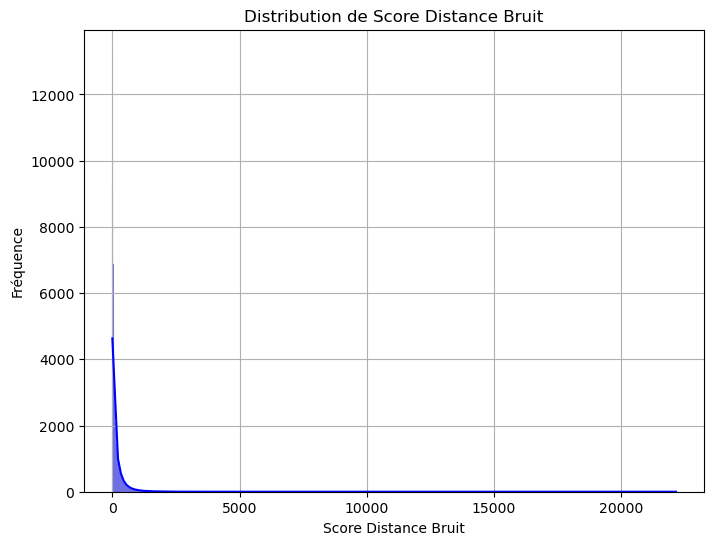

In [62]:
# Distribution de score_distance_bruit
plt.figure(figsize=(8, 6))
sns.histplot(score_bruit['score_distance_bruit'], kde=True, color='blue')
plt.title('Distribution de Score Distance Bruit')
plt.xlabel('Score Distance Bruit')
plt.ylabel('Fréquence')
plt.grid()

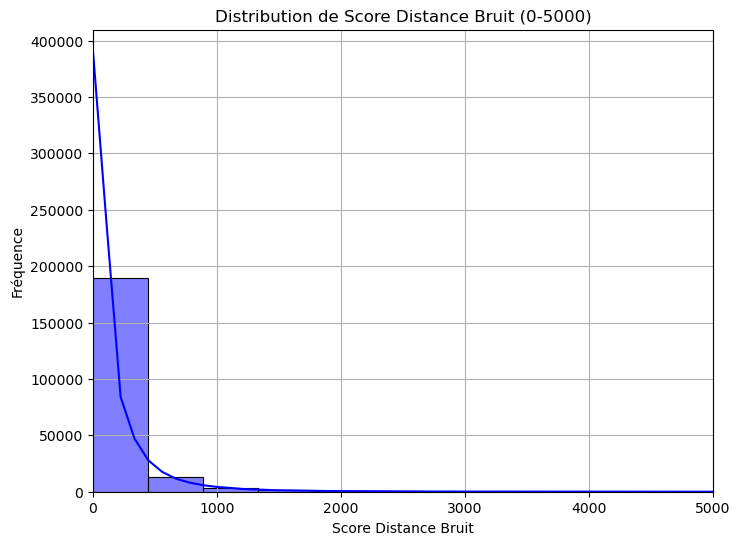

In [63]:
# Distribution de score_distance_bruit limitée à 0-5000
plt.figure(figsize=(8, 6))
sns.histplot(score_bruit['score_distance_bruit'], kde=True, bins=50, color='blue')
plt.title('Distribution de Score Distance Bruit (0-5000)')
plt.xlabel('Score Distance Bruit')
plt.ylabel('Fréquence')
plt.xlim(0, 5000)  
plt.grid()

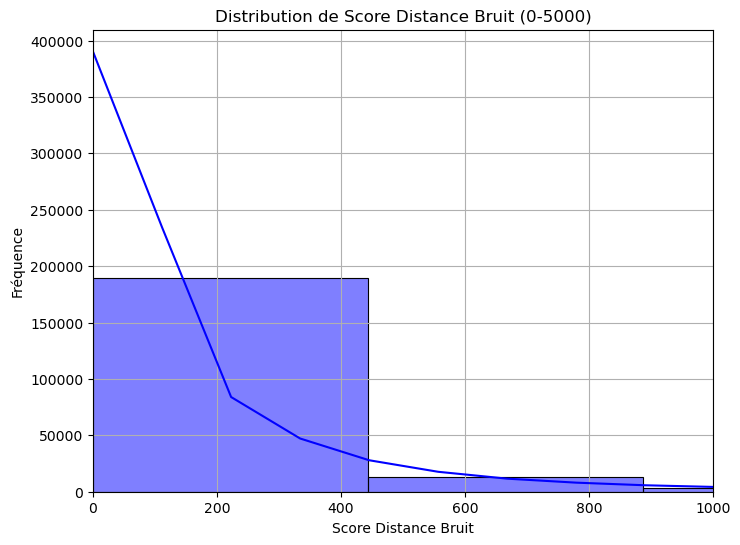

In [64]:
# Distribution de score_distance_bruit limitée à 0-1000
plt.figure(figsize=(8, 6))
sns.histplot(score_bruit['score_distance_bruit'], kde=True, bins=50, color='blue')
plt.title('Distribution de Score Distance Bruit (0-5000)')
plt.xlabel('Score Distance Bruit')
plt.ylabel('Fréquence')
plt.xlim(0, 1000)  
plt.grid()

# Loi normale 

/home/alexandre-ober/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 209441.
  res = hypotest_fun_out(*samples, **kwds)


La p-value (9.26229990376e-186) est inférieure à 0.05. Les données ne suivent pas une distribution normale.


Text(0, 0.5, 'Q distri bruit')

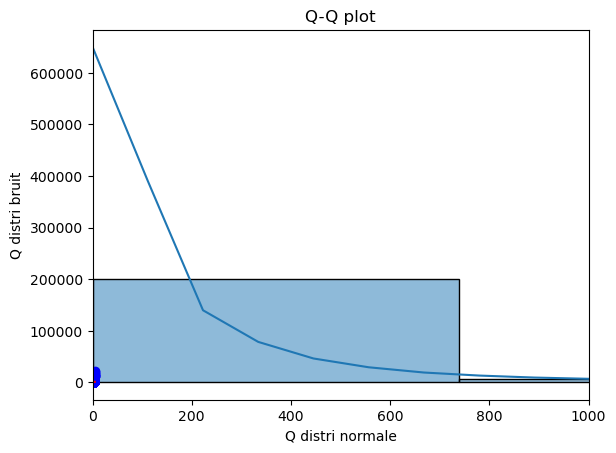

In [65]:
# Test de Shapiro-Wilk
stat, p_value = stats.shapiro(score_bruit['score_distance_bruit'])
seuil = 0.05

# Décision basée sur la p-value
if p_value < seuil:
    print(f"La p-value ({p_value}) est inférieure à {seuil}. Les données ne suivent pas une distribution normale.")
else:
    print(f"La p-value ({p_value}) est supérieure à {seuil}. Les données peuvent suivre une distribution normale.")


# Histo
sns.histplot(score_bruit['score_distance_bruit'], kde=True, bins=30)
plt.title('Loi normale')
plt.xlabel('DN')
plt.ylabel('Occurence')
plt.xlim(0,1000)
# Q-Q plot
stats.probplot(score_bruit['score_distance_bruit'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.xlabel('Q distri normale')
plt.ylabel('Q distri bruit')

# Colonne Length

(0.0, 20.0)

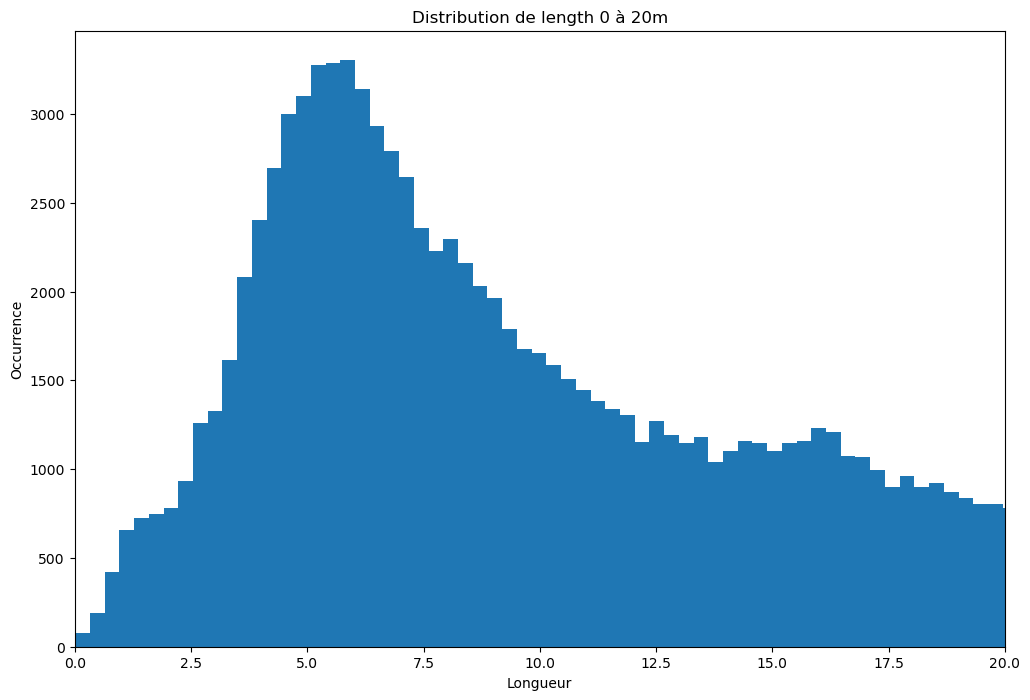

In [66]:
plt.figure(figsize=(12, 8))
plt.hist(score_bruit['length'], bins=10000)
plt.title("Distribution de length 0 à 20m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')
plt.xlim(0, 20)

(20.0, 40.0)

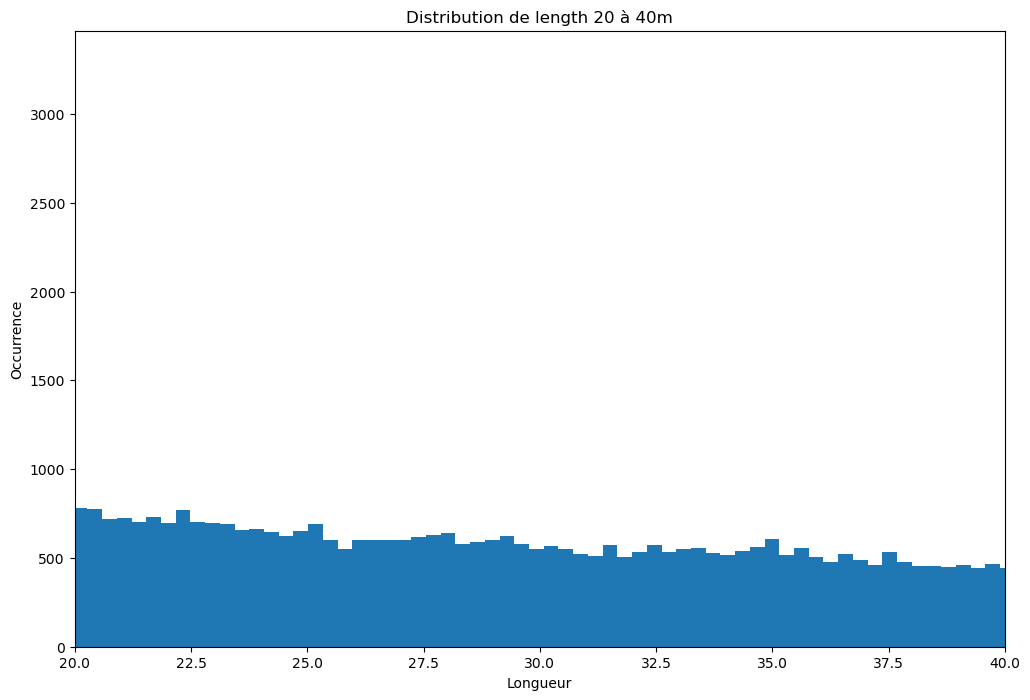

In [67]:
plt.figure(figsize=(12, 8))
plt.hist(score_bruit['length'], bins=10000)
plt.title("Distribution de length 20 à 40m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')
plt.xlim(20, 40)

(40.0, 100.0)

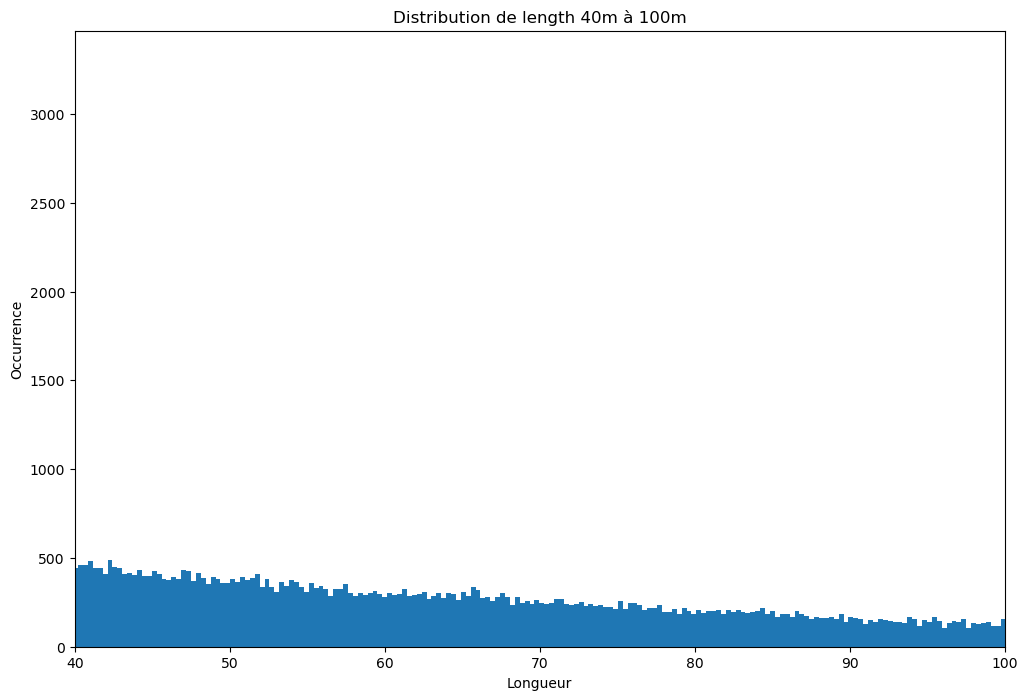

In [68]:
plt.figure(figsize=(12, 8))
plt.hist(score_bruit['length'], bins=10000)
plt.title("Distribution de length 40m à 100m")
plt.xlabel('Longueur')
plt.ylabel('Occurrence')
plt.xlim(40, 100)

In [69]:
moy_l =score_bruit['length'].mean()
var_l = score_bruit['length'].var()
q_l = score_bruit['length'].quantile([0.25, 0.5, 0.75])
min_l =score_bruit['length'].min()
max_l = score_bruit['length'].max()
print(f"La moyenne de la colonne du length est de :\n{moy_l} m")
print(f"La variance de la colonne du length est de :\n{var_l}")
print(f"Les quantiles de la colonne du length sont de :\n{q_l}")
print(f"Le minimum de la colonne du length est de :\n{min_l} m")
print(f"Le maximum de la colonne du length est de :\n{max_l} m")

La moyenne de la colonne du length est de :
47.918175992284226 m
La variance de la colonne du length est de :
5512.348479845816
Les quantiles de la colonne du length sont de :
0.25     8.545
0.50    23.538
0.75    59.784
Name: length, dtype: float64
Le minimum de la colonne du length est de :
0.011 m
Le maximum de la colonne du length est de :
3165.715 m


### Loi normale 

La p-value (2.963780466189736e-176) est inférieure à 0.05. Les données ne suivent pas une distribution normale.


/home/alexandre-ober/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 209441.
  res = hypotest_fun_out(*samples, **kwds)


Text(0, 0.5, 'Occurence')

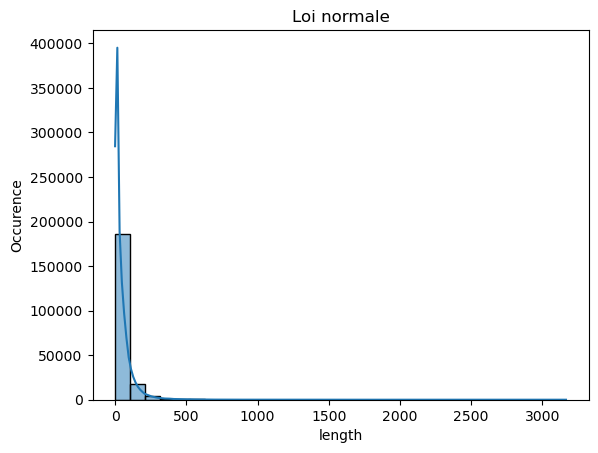

In [70]:
# Test de Shapiro-Wilk
stat, p_value = stats.shapiro(score_bruit['length'])
seuil = 0.05

# Décision basée sur la p-value
if p_value < seuil:
    print(f"La p-value ({p_value}) est inférieure à {seuil}. Les données ne suivent pas une distribution normale.")
else:
    print(f"La p-value ({p_value}) est supérieure à {seuil}. Les données peuvent suivre une distribution normale.")


# Histo
sns.histplot(score_bruit['length'], kde=True, bins=30)
plt.title('Loi normale')
plt.xlabel('length')
plt.ylabel('Occurence')


Text(0, 0.5, 'Q distri length')

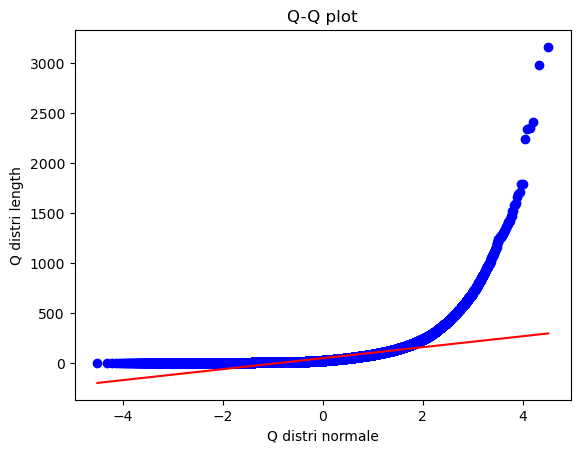

In [71]:
# Q-Q plot
stats.probplot(score_bruit['length'], dist="norm", plot=plt)
plt.title('Q-Q plot')
plt.xlabel('Q distri normale')
plt.ylabel('Q distri length')

# Relation entre score_distance_bruit et length

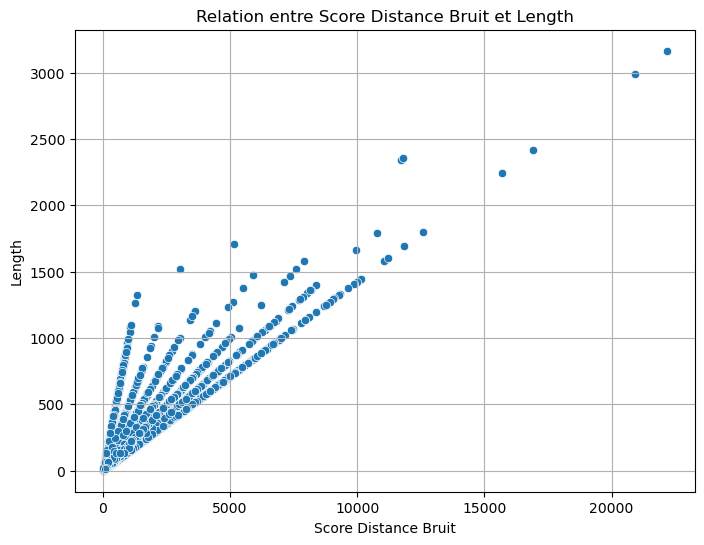

In [72]:
# Regarder la relation entre score_distance_bruit et length 

plt.figure(figsize=(8, 6))
sns.scatterplot(x='score_distance_bruit', y='length', data=score_bruit)
plt.title('Relation entre Score Distance Bruit et Length')
plt.xlabel('Score Distance Bruit')
plt.ylabel('Length')
plt.grid()

##  Corrélation entre le score_distance_bruit et la longueur des segments 


In [73]:
corr = score_bruit['score_distance_bruit'].corr(score_bruit['length'])
print(f"Coefficient de corrélation : {corr}")

Coefficient de corrélation : 0.8473568030159595


Text(0.5, 1.0, 'Heatmap des corrélations : Score Distance Bruit vs Length')

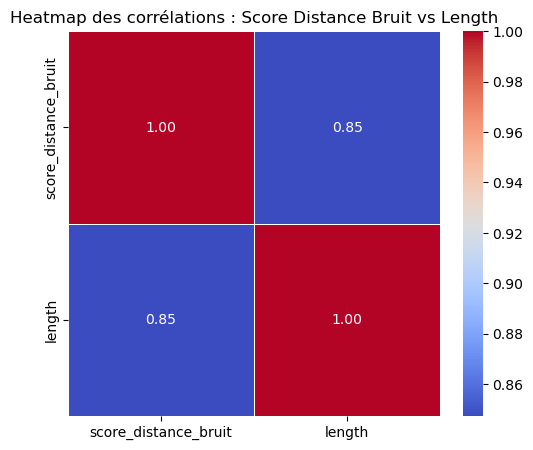

In [74]:
# Heatmap 'length' et 'score_distance_bruit'
selected_columns = ['score_distance_bruit', 'length']
correlation_matrix = score_bruit[selected_columns].corr()

# graph
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap des corrélations : Score Distance Bruit vs Length')